In [3]:
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
import numpy.linalg as la
import os
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy import stats as st
from scipy.fft import fft, fftfreq
import sys
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
np.set_printoptions(precision=2)
%matplotlib inline
plt.style.use(style='seaborn-v0_8')

In [4]:
'''df1 = pd.read_csv(r'ITC.NS.csv')print(df1.shape)df = df1[['Close']].copy()#df.loc[len(df.index)]=408.3df.to_csv(r'ITC.NS.csv')df.shape'''

"df1 = pd.read_csv(r'ITC.NS.csv')print(df1.shape)df = df1[['Close']].copy()#df.loc[len(df.index)]=408.3df.to_csv(r'ITC.NS.csv')df.shape"

In [5]:
def getData(name, per, intrvl, cols = ['Close']):
    df = yf.Ticker(name)
    df = pd.DataFrame(df.history(period=per, interval=intrvl))
    
    return df[cols].copy()

In [42]:
def minMax(df, lower, upper):
    vec = np.array(df)
    #print(df)
    for j in np.arange(vec.shape[1]):
        min = np.min(vec[:,j])
        max = np.max(vec[:,j])
        for i in np.arange(vec.shape[0]):
            vec[i,j] = ((vec[i,j] - min)/(max-min))*(upper-lower)+lower

    return vec

inner = lambda a,b: np.prod(a[:]+b[:])


In [21]:
class LinearRegression:
    #multivar linear regression
    def __init__(self, df, *cols):
        #if len(col)==2:
            self.new_mat = pd.DataFrame()
            self.columns = np.array(cols)
            for col in cols:
                self.new_mat[df.iloc[:,col-1:col].columns] = np.array(df.iloc[:,col-1:col])
                
            self.m = self.new_mat.shape
            self.X_train = pd.DataFrame()
            self.y_train = pd.DataFrame()
            self.U = np.empty([self.m[1],self.m[1]], dtype=float)
            self.V = np.empty([self.m[1],1], dtype=float)
            self.W = np.empty([self.m[1],1], dtype=float)
            
        #else:
            #print("Enter two Columns")
            
    def show(self):
        display(self.new_mat)
        
    def target(self, target):
        
        self.y_train[self.new_mat.iloc[:,target-1:target].columns] = np.array(self.new_mat.iloc[:,target-1:target])
        #display(self.y_train)
        self.X_train = self.new_mat.drop(self.y_train.columns, axis=1)
        #self.X_train['1'] = 1 
        sums = np.array([])
        for col in np.delete(np.arange(self.m[1]), target-1):
            sums = np.append(sums, np.sum(self.new_mat.iloc[:,col]))
            
        trgt_sum = np.sum(self.new_mat.iloc[:,target-1])  #here
        
        for i in np.arange(len(sums)):
            self.U[0][i] = sums[i]
            
        self.U[0][-1] = self.new_mat.iloc[:,target-1].count()
        
        self.V[0][0] = trgt_sum
        
        for i in np.arange(len(sums)):
            for j in np.arange(len(sums)):
                self.U[i+1][j] = np.sum(self.X_train.iloc[:,j]/self.X_train.iloc[:,i])
                
            self.U[i+1][-1] = np.sum(1/self.X_train.iloc[:,i])
            self.V[i+1][0] = np.sum(self.y_train.iloc[:,0]/self.X_train.iloc[:,i])   #here
                
        self.W = la.inv(self.U) @ self.V
        #print(self.W)
        
    def predict(self, *test_data):
        pred_val = 0
        i = 0
        for value in test_data:
            pred_val += self.W[i][0]*value
            #print(self.W[i][0],value,pred_val)
            i+=1
        
        return pred_val + self.W[-1][0]
    
    def plot(self, sz=10, wd=1):
        if self.X_train.shape[1]==1:
            ledgy = list()
            y_pred = np.array([])
            for i in np.arange(self.m[0]):
                 y_pred = np.append(y_pred, self.predict(*tuple(self.X_train.iloc[i,:])))
                
            for col in np.arange(1,self.m[1]):
                plt.scatter((self.X_train.iloc[:,col-1:col]), (self.y_train), color=(np.random.random(),np.random.random(),np.random.random()), s=sz)
                ledgy.append(self.X_train.iloc[:1,col-1:col].columns[0])
            
            plt.plot((self.X_train.iloc[:,:1]), (y_pred), color=(np.random.random(),np.random.random(),np.random.random()), linewidth=wd+0.5)
            plt.legend(ledgy, loc=(1,0.7))
            plt.ylabel(self.y_train.iloc[:1,:1].columns[0])
            plt.show()
        else:
            return "Please Enter one on one relation"
    
    def error(self,perc=80):
        if self.X_train.shape[1]>=-1:
            y_pred = np.array([])
            for i in np.arange(self.m[0]):
                y_pred = np.append(y_pred, self.predict(*tuple(self.X_train.iloc[i,:])))
                
            #acc = 100 - ((abs(np.reshape(np.array(self.y_train), (self.m[0],))-y_pred)/np.reshape(np.array(self.y_train), (self.m[0],)))*100)
            #print(len(abs(np.reshape(np.array(self.y_train), (22,))-y_pred)/np.reshape(np.array(self.y_train), (22,))))
            acc = abs(np.reshape(np.array(self.y_train), (self.m[0],))-y_pred)
            sns.boxplot(acc)
            plt.show()
            sns.histplot(acc, kde=True)
            plt.show()
            print(f'mean:{np.mean(acc)},std:{np.std(acc)}')
            return np.percentile(acc,perc)
        else:
            return "Please Enter one on one relation"

In [22]:
df1 = getData(name = 'adanient.ns', per= '20d', intrvl= '15m')
#df1=df1*(834/28.34)
#df1.to_csv('stock_data.csv')
#df1 = pd.DataFrame(fft(df1))

In [23]:
df1.shape

(500, 1)

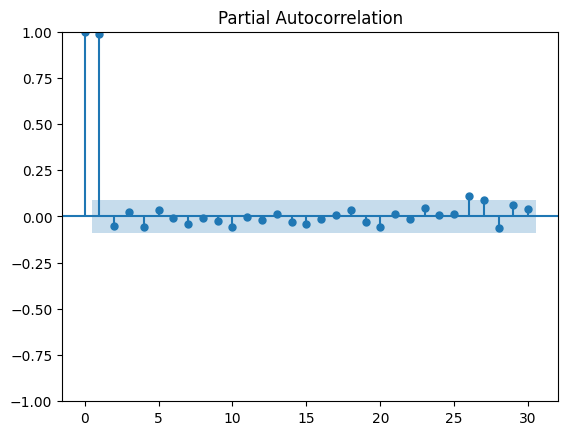

In [24]:
plot_pacf(df1, lags=30);

In [25]:
n_lags = 26
temp = [df1]+[df1.shift(-i) for i in np.arange(1,n_lags+1)]


In [26]:
#dff = pd.concat([df1,df1['Close'].shift(-1),df1['Close'].shift(-2),df1['Close'].shift(-3),df1['Close'].shift(-4),df1['Close'].shift(-5),df1['Close'].shift(-6),df1['Close'].shift(-7)], axis=1)

cols = [
        df1,df1.shift(-1),
        df1.shift(-29),
        df1.shift(-36),
        # df1.shift(-34),
        # # df1.shift(-2),
        # # df1.shift(-3),
        # # df1.shift(-4),
        ]

cols = temp

dff = pd.concat(cols, axis=1)
#dff = pd.concat([df1,df1['Close'].shift(-1),df1['Close'].shift(-2),df1['Close'].shift(-3),df1['Close'].shift(-4),df1['Close'].shift(-5)], axis=1)
dff.columns = np.arange(len(cols))
dff = dff.dropna()
dff.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-04-09 14:00:00+05:30,3187.399902,3196.399902,3196.300049,3209.000000,3199.000000,3200.550049,3210.000000,3211.100098,3207.600098,3201.600098,...,3217.199951,3217.149902,3221.800049,3220.000000,3240.149902,3235.000000,3236.000000,3234.449951,3233.100098,3243.100098
2024-04-09 14:15:00+05:30,3196.399902,3196.300049,3209.000000,3199.000000,3200.550049,3210.000000,3211.100098,3207.600098,3201.600098,3200.000000,...,3217.149902,3221.800049,3220.000000,3240.149902,3235.000000,3236.000000,3234.449951,3233.100098,3243.100098,3241.000000
2024-04-09 14:30:00+05:30,3196.300049,3209.000000,3199.000000,3200.550049,3210.000000,3211.100098,3207.600098,3201.600098,3200.000000,3201.350098,...,3221.800049,3220.000000,3240.149902,3235.000000,3236.000000,3234.449951,3233.100098,3243.100098,3241.000000,3235.199951
2024-04-09 14:45:00+05:30,3209.000000,3199.000000,3200.550049,3210.000000,3211.100098,3207.600098,3201.600098,3200.000000,3201.350098,3195.000000,...,3220.000000,3240.149902,3235.000000,3236.000000,3234.449951,3233.100098,3243.100098,3241.000000,3235.199951,3238.800049
2024-04-09 15:00:00+05:30,3199.000000,3200.550049,3210.000000,3211.100098,3207.600098,3201.600098,3200.000000,3201.350098,3195.000000,3199.000000,...,3240.149902,3235.000000,3236.000000,3234.449951,3233.100098,3243.100098,3241.000000,3235.199951,3238.800049,3245.000000


In [27]:
#sns.heatmap(dff.corr(), annot=True, cmap='RdBu')
def AGO(df):
    cdf = df.copy()
    out = pd.DataFrame()
    for i in np.arange(cdf.shape[0]):
        row = np.array(cdf.iloc[i,:])
        #print(len(row))
        x= [row[j] - row[j-1] for j in np.arange(1,len(row))]
        out[i] = x
        #print(pd.Series(x))
    return out.T

In [28]:
n = 0.95
size  = int(df1.shape[0]*n)
size = dff.shape[0]-20
df_train = dff.iloc[:size,:]
df_test = dff.iloc[size:,:]

In [29]:
lr = LinearRegression(df_train, *np.arange(1,len(cols)+1))

In [30]:
np.arange(1,len(cols)+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [31]:
lr.target(np.arange(1,len(cols)+1)[-1])
#lr.show()

In [32]:
l = list()
rangep = np.array([(400,408.25),(409,411.5),(411.5,412),(412,413)])
for i in np.arange(df_test.shape[0]):
    l.append(lr.predict(*(df_test.iloc[i,:-1])))
l=np.array(l)

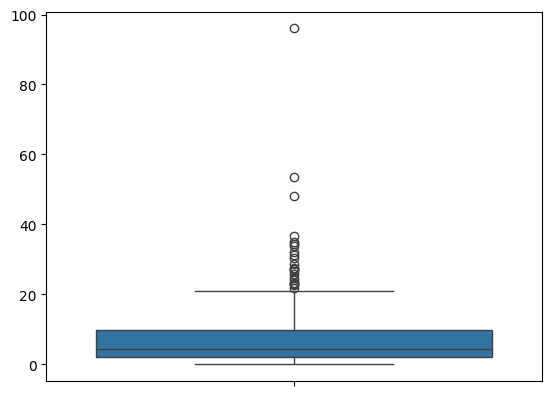

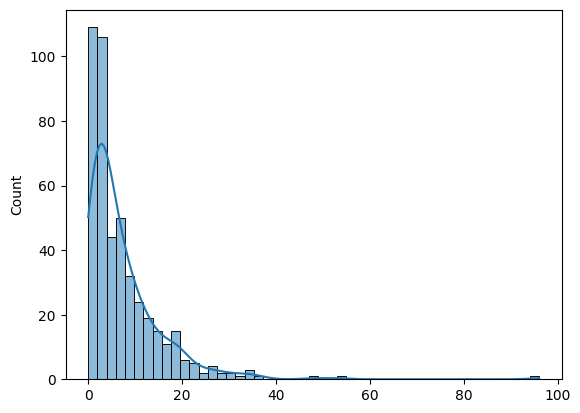

mean:7.300520512672457,std:8.534592209957761


13.77358536368895

In [33]:
#intv=abs((np.array(df_test.iloc[:,2])-l)).mean()
intv=lr.error(85)
intv

In [34]:
#print(f'predicted:{np.array(l+intv),np.array(l-intv)}')

In [35]:
def plot_predict(actual,l, intv,t=-1, title = False):
    plt.figure(figsize=(5,3.8))
    lower,upper = l-intv,l+intv
    actual = np.arange(-len(l),len(np.array(df_test.iloc[:,-1])))
    #print(actual)
    plt.plot(np.array(df_test.iloc[:,t]), c='k', alpha=0.4) #np.array(df_test.iloc[:,-1])
    #print(np.array(df_test.iloc[:,-1]))
    plt.plot(lower[1:],'r--', label='lower')
    plt.plot(l[1:], c='b',label = 'predicted')
    plt.plot(upper[1:],'g--', label='upper')
    plt.legend(loc='upper left')
    if title:
        plt.title('My Model')
    plt.show()
    

In [36]:
def forec_tree(prev_days,price, intv, depth, fluctFact=0.25, dr=1):
    prev_days = np.append(prev_days, price)
    prev_days = prev_days[1:]
    udr = 0.8
    ldr = 1.25
    m = m1 = lr.predict(*prev_days)
    #prev_days = np.append(prev_days, m)
    up,low = m+intv,m-intv
    disth = dr*abs(price-up)
    distl = abs(price-low)
    factor = distl/(distl+disth)
    if depth==-5:
        #print("in -5")
        return factor
        
    if depth<=0 and depth>-5:
        u = forec_tree(prev_days, price+(fluctFact)*1*intv, intv, depth-1, fluctFact= fluctFact, dr=1 if fluctFact<=0.5 or fluctFact >= 1.2 else udr*dr)
        d = forec_tree(prev_days, price+(fluctFact)*1*intv, intv, depth-1, fluctFact= fluctFact, dr=1 if fluctFact<=0.5 or fluctFact >= 1.2 else ldr*dr)
        #print(f"IF {price:7.6} THEN:{factor:5.2},up:{up:7.6},mean:{m1:7.6},low:{low:7.6} d({depth-1})\n")
        return (factor*u*d)**(1/3)
    
    elif depth>0:
        d = forec_tree(prev_days,price-(fluctFact)*1*intv, intv, depth-1, fluctFact=fluctFact,dr=1 if fluctFact<=0.5 or fluctFact >=1.2 else ldr*dr)
        #print(f"IF {price:7.6} THEN:{factor:5.2},up:{up:7.6},mean:{m1:7.6},low:{low:7.6} d({depth-1})\n")
        u = forec_tree(prev_days,price+(fluctFact)*1*intv, intv, depth-1, fluctFact=fluctFact,dr=1 if fluctFact<=0.5 or fluctFact >= 1.2 else udr*dr)
        factor = (factor*d*u)**(1/3)
        print(f"IF {price:7.6} THEN: {factor:5.2},up:{up:7.6},mean:{m1:7.6},low:{low:7.6} d({depth-1})\n")
        return factor

In [37]:
def forec(price_today, n_points, t=-1, read=True):
    price_today = float(df_test.iloc[t,-1])
    prev_days = np.append(np.array(df_test.iloc[t-1,:-1]), price_today)
    prev_days = prev_days[1:]
    output = np.empty((n_points,4))
    #print(prev_days)
    for i in np.arange(n_points):
        m = m1 = lr.predict(*prev_days)
        up,low = m+intv,m-intv
        disth = abs(price_today-up)
        distl = abs(price_today-low)
        factor = distl/(distl+disth)
        output[i][0] = factor
        output[i][1] = up
        output[i][2] = m1
        output[i][3] = low
        '''if factor<0.47:
            m = price_today = (m+(factor*.001*m))
        else:
            m = price_today = (m-factor*.001*m)'''
        price_today = m
        prev_days = np.append(np.array(prev_days),price_today)
        prev_days = prev_days[1:]
        if read:
            print(f'[{factor:5.2}, up: {up:7.6}, mean: {m1:7.6}, low: {low:7.6}], {float(df_test.iloc[t,-1]):7.6}')
    if read==False:
        return output


In [38]:
df_test.tail()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-04-09 14:00:00+05:30,3187.399902,3196.399902,3196.300049,3209.000000,3199.000000,3200.550049,3210.000000,3211.100098,3207.600098,3201.600098,...,3217.199951,3217.149902,3221.800049,3220.000000,3240.149902,3235.000000,3236.000000,3234.449951,3233.100098,3243.100098
2024-04-09 14:15:00+05:30,3196.399902,3196.300049,3209.000000,3199.000000,3200.550049,3210.000000,3211.100098,3207.600098,3201.600098,3200.000000,...,3217.149902,3221.800049,3220.000000,3240.149902,3235.000000,3236.000000,3234.449951,3233.100098,3243.100098,3241.000000
2024-04-09 14:30:00+05:30,3196.300049,3209.000000,3199.000000,3200.550049,3210.000000,3211.100098,3207.600098,3201.600098,3200.000000,3201.350098,...,3221.800049,3220.000000,3240.149902,3235.000000,3236.000000,3234.449951,3233.100098,3243.100098,3241.000000,3235.199951
2024-04-09 14:45:00+05:30,3209.000000,3199.000000,3200.550049,3210.000000,3211.100098,3207.600098,3201.600098,3200.000000,3201.350098,3195.000000,...,3220.000000,3240.149902,3235.000000,3236.000000,3234.449951,3233.100098,3243.100098,3241.000000,3235.199951,3238.800049
2024-04-09 15:00:00+05:30,3199.000000,3200.550049,3210.000000,3211.100098,3207.600098,3201.600098,3200.000000,3201.350098,3195.000000,3199.000000,...,3240.149902,3235.000000,3236.000000,3234.449951,3233.100098,3243.100098,3241.000000,3235.199951,3238.800049,3245.000000


In [39]:
t = -1
#-k mean previous k days
print(np.array(df_test.iloc[t,:-1]),df_test.iloc[t,-1])
#print(np.array([400.14,398.5,398.75,400.23]))
#aaj ka close and previous k days ka close, AR(k) here k=5

[3199.   3200.55 3210.   3211.1  3207.6  3201.6  3200.   3201.35 3195.
 3199.   3206.2  3213.75 3214.65 3217.2  3217.15 3221.8  3220.   3240.15
 3235.   3236.   3234.45 3233.1  3243.1  3241.   3235.2  3238.8 ] 3245.0


In [40]:
price_today = float(df_test.iloc[t,-1])

yesterday = np.array(df_test.iloc[t,:-1])*1 
pred_high_today,m,pred_low_today = (lr.predict(*yesterday)+intv,lr.predict(*yesterday),lr.predict(*yesterday)-intv)
#decision = [1 if price[-1]<high else 0, 1 if price[-1]<m else 0,  1 if price[-1]<low else 0]
#print(price_today<pred_high_today, price_today>pred_low_today)
today = list(yesterday[1:])
today.append(price_today)
today = np.array(today)
#print(today)
pred_high_tom,m,pred_low_tom = lr.predict(*today)+intv,lr.predict(*today),lr.predict(*today)-intv
if price_today<pred_high_today and price_today>pred_low_today:
    '''today = list(yesterday[1:])
    today.append(price_today)
    today = np.array(today)
    #print(today)
    pred_high_tom,m,pred_low_tom = (lr.predict(*today)+intv,lr.predict(*today),lr.predict(*today)-intv)'''
    distfh = abs(price_today-pred_high_tom)#np.sqrt((price_today-pred_high_tom)**2)
    distfl = abs(price_today-pred_low_tom)#np.sqrt((price_today-pred_low_tom)**2)
    #print(price_today-pred_high_tom,price_today-pred_low_tom)
    factor = distfl/(distfh+distfl)
    print(factor,f'Tom_Upper: {pred_high_tom}, Tom_Lower: {pred_low_tom}, mean:{m}')

else:
    sigdhl = abs(price_today-pred_high_today) 
    sigdfl = abs(price_today-pred_low_today)
    
    distfh = abs(price_today-pred_high_tom)
    distfl= abs(price_today-pred_low_tom)
    factor = distfl/(distfl+distfh)
    print(f'significance = {sigdhl/intv:4.3}')
    print(f'{factor:5.2}',f'Tom_Upper:{pred_high_tom:7.5}, Tom_Lower:{pred_low_tom:7.5}, mean:{m:7.5}, Tod_Upper: {pred_high_today:7.5}, Tod_Lower: {pred_low_today:7.5}')     
    #decision boundary is around factor=0.35   
    #factor below 0.35 then down 
    #if significance below 0.4 and above 1 then use pred_tom for dists
    #if significance bw 0.4 and 1 then use pred_today for dists

0.5726747783385849 Tom_Upper: 3256.7716008372217, Tom_Lower: 3229.2244301098435, mean:3242.9980154735326


In [43]:

#np.append(l,np.array((forec(411.75,7,t=-1,read=False)[:,2])))
dev = np.std(minMax(df1.tail(10), 0 , 1))
dev

0.32153560334449016

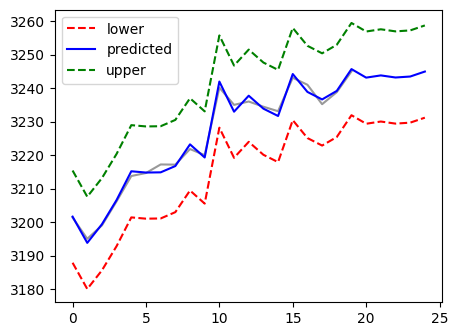

In [44]:
plot_predict(today,np.append(l,np.array((forec(3187.95,6,t=-1,read=False)[:,2]))),intv,t=-1)

In [45]:
t=-1
prev_days = np.array(df_test.iloc[t,:-1])
forec_tree(prev_days,float(df_test.iloc[t,-1]),
           intv,
           depth=3,
           fluctFact= dev*1)


IF 3236.14 THEN:   0.5,up: 3249.7,mean:3235.92,low:3222.15 d(0)

IF  3245.0 THEN:   0.5,up: 3259.0,mean:3245.22,low:3231.45 d(0)

IF 3240.57 THEN:   0.5,up:3254.38,mean:3240.61,low:3226.84 d(1)

IF  3245.0 THEN:  0.51,up:3258.17,mean: 3244.4,low:3230.62 d(0)

IF 3253.86 THEN:   0.5,up:3267.47,mean: 3253.7,low:3239.92 d(0)

IF 3249.43 THEN:   0.5,up:3263.69,mean:3249.91,low:3236.14 d(1)

IF  3245.0 THEN:  0.52,up:3256.77,mean: 3243.0,low:3229.22 d(2)



0.5230133539515734

In [46]:
forec(3187.95,3,t=t )

[ 0.48, up: 3259.45, mean: 3245.68, low: 3231.91],  3245.0
[ 0.59, up: 3256.91, mean: 3243.13, low: 3229.36],  3245.0
[ 0.48, up: 3257.57, mean:  3243.8, low: 3230.02],  3245.0


In [47]:
df1.tail(10)

,Close
Datetime,
2024-04-10 13:00:00+05:30,3240.149902
2024-04-10 13:15:00+05:30,3235.000000
2024-04-10 13:30:00+05:30,3236.000000
2024-04-10 13:45:00+05:30,3234.449951
2024-04-10 14:00:00+05:30,3233.100098
2024-04-10 14:15:00+05:30,3243.100098
2024-04-10 14:30:00+05:30,3241.000000
2024-04-10 14:45:00+05:30,3235.199951
2024-04-10 15:00:00+05:30,3238.800049


In [48]:
from PIL import Image

In [49]:
def convolve2D(sqmat,conmat):
    conshape = conmat.shape[0]
    sqmat = sqmat[:(conshape*(sqmat.shape[0]//conshape)), :(conshape*(sqmat.shape[1]//conshape))]
    newmat = np.empty(shape=(sqmat.shape[0]-conshape//2,sqmat.shape[0]-conshape//2))
    for row in np.arange(conshape//2,sqmat.shape[0]-(conshape//2)-1):
        for col in np.arange(conshape//2,sqmat.shape[0]-(conshape//2)-1):
            mini = np.array([[sqmat[i,j] for i in np.arange(row-(conshape//2), row+(conshape//2)+1)] for j in np.arange(col-(conshape//2), col+(conshape//2)+1)])
            newmat[row,col] = np.sum([[mini[i,j]*conmat[i,j] for i in np.arange(conshape)] for j in np.arange(conshape)])
    
    return newmat


In [50]:
def minmaxImager(df, lower=0,upper=16, convolve = False):
    vec = minMax(df, lower, upper)
    sqmat = vec @ vec.T
    #print(sqmat.shape)
    if isinstance(convolve,np.ndarray):
        conmat = np.array(convolve)
        cmat = convolve2D(sqmat=sqmat, conmat=conmat)
        img = Image.fromarray(cmat)
        return img.show()
    else:
        img = Image.fromarray(sqmat)
        return img.show()

In [51]:
col = [
    'High',
    #'Close',
    'Low'
       ]
df = getData('usdinr=x', per = '3wk', intrvl='15m',cols=col)
df = df if len(col)==1 else np.array(abs(df.iloc[:,0:1]))-np.array(abs(df.iloc[:,1:2]))
#df

In [53]:
weights=np.reshape(lr.W, (lr.W.shape[0],))

In [54]:
def MSE(w,X,y_true, diff=False):
    y_pred = np.empty((y_true.shape[0],))
    for row in np.arange(X.shape[0]):
        #z = np.array(X.iloc[row,:]).T @ w[:-1]- 1*w[-1]
        y_pred[row] = (np.array(X.iloc[row,:]) @ w[:-1].T)+ 1*w[-1]
        #print(np.array(X.iloc[row,:]) , w[:-1].T, 1*w[-1])
        #break
        
    #MSE = ((np.array(lr.y_train).reshape(lr.y_train.shape[0],)-y_pred)**2)
    if diff:
        MSE = (np.array(lr.y_train).reshape(lr.y_train.shape[0],)-y_pred)
        return MSE.mean()
    else:
        MSE = ((np.array(lr.y_train).reshape(lr.y_train.shape[0],)-y_pred)**2)
        return MSE.mean()

In [55]:
MSE(weights,lr.X_train,lr.y_train,diff=False)

126.136863946223

In [56]:
a = MSE(weights,lr.X_train,lr.y_train,diff=True)

In [57]:
weights

array([ 9.52e-02, -1.02e-01,  3.05e-02,  2.17e-02, -5.37e-02,  3.43e-02,
       -8.60e-02,  4.18e-02,  5.41e-02, -2.15e-02, -1.55e-02, -6.25e-02,
        3.47e-02,  4.60e-02, -2.01e-02, -2.49e-02, -5.28e-02,  5.39e-02,
        6.84e-03, -2.57e-02,  4.83e-02,  3.75e-02, -9.79e-02,  9.01e-02,
       -9.35e-02,  1.05e+00,  3.37e+01])

In [60]:
# import autobnn as ab
# import jax
# model = ab.operators.Add(
#     bnns=(ab.kernels.PeriodicBNN(width=n_lags,period=n_lags),
#           ab.kernels.OneLayerBNN(width=n_lags, period=n_lags),
#           ab.kernels.LinearBNN(width=n_lags),
#           ab.kernels.MaternBNN(width=n_lags)))

# estimator = ab.estimators.AutoBnnMapEstimator(
#     model, 'normal_likelihood_logistic_noise', jax.random.PRNGKey(42),
#     periods=[n_lags])

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
# X = np.array(dff.drop(n_lags,axis=1))
# y = np.array(dff[n_lags])
# estimator.fit(X[:-20], y)

In [100]:
# low, mid, high = estimator.predict_quantiles(X[-20:],(10,50,90))
# p = estimator.predict(X[-20:])

In [101]:
# print(np.mean((abs(np.array(df1.tail(20))-mid))))

20.357035


In [63]:
# show = 20
# x = np.arange(1,show+1)
# plt.plot(np.array(df1.tail(show)),c='k', alpha=0.4)
# plt.plot(mid,)
# plt.plot(low, '--r')
# plt.plot(high, '--g')
# plt.title('AutoBNN')
# plt.legend(['Actual','Predicted','Lower','Upper'])

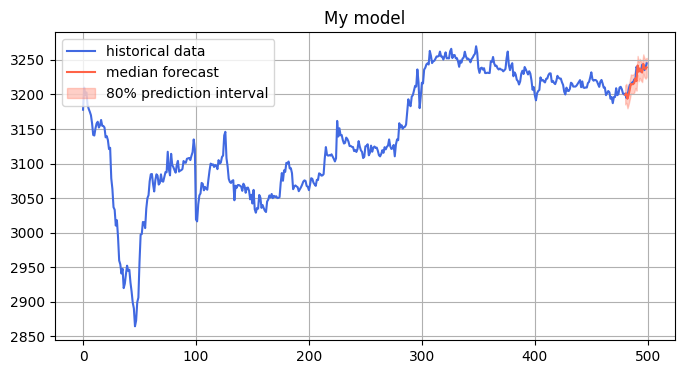

In [64]:
plt.style.use(style='default')
forecast_index = range(len(df1)-20,len(df1))
plt.figure(figsize=(8, 4))
plt.plot(np.array(df1), color="royalblue", label="historical data")
plt.plot(forecast_index, l, color="tomato", label="median forecast")
plt.fill_between(forecast_index, l-intv, l+intv, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend(loc="upper left")
plt.title("My model")
plt.grid(True)
plt.show()

In [65]:
import torch
from chronos import ChronosPipeline

In [66]:
# for plotting, run: pip install pandas matplotlib

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

df = getData(name = 'adanient.ns', per= '20d', intrvl= '15m')
prediction_length = 20
n_lags = 26
df_train = df.head(len(df)-prediction_length)
df_test = df.tail(prediction_length)
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df_train.to_numpy())

forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=n_lags,
    temperature=1.0,
    top_k=100,
    top_p=50,
) # forecast shape: [num_series, num_samples, prediction_length]

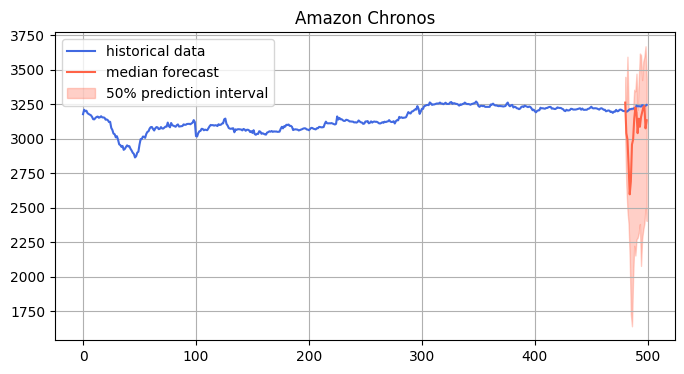

In [67]:
# visualize the forecast
plt.style.use(style='default')
forecast_index = range(len(df_train), len(df_train) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.25, 0.5, 0.75], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(np.array(df), color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="50% prediction interval")
plt.legend(loc="upper left")
plt.title('Amazon Chronos')
plt.grid()
plt.show()